In [2]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# # rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr

print(sns.__version__)

0.13.2


In [2]:
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amsmath, bbm}\usepackage{amssymb}\usepackage{amsfonts}\usepackage{amsthm}')
# # matplotlib.verbose.level = 'debug-annoying'
# import matplotlib
# matplotlib.__version__
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['mathtext.fontset'] = 'cm'  # Other options: 'cm' (Computer Modern), 'stixsans', 'stix', custom...
plt.rcParams['mathtext.rm'] = 'serif:scaled=1.5'  # Scale the serif font (default for math text) by 1.5 times
plt.rcParams['mathtext.it'] = 'serif:scaled=1.5'
plt.rcParams['mathtext.tt'] = 'serif:scaled=1.5'
plt.rcParams['mathtext.sf'] = 'serif:scaled=1.5'
# plt.rcParams.update({'font.size': 16})

# plt.rcParams['font.family'] = 'sans-serif'
# # plt.rcParams['mathtext.default'] = 'regular'  # Ensure regular style is used for mathtext
# plt.rcParams['mathtext.fontset'] = 'cm'  # Choose a fontset, e.g., 'stix', 'cm' (Computer Modern)
# plt.rcParams['mathtext.rm'] = 'serif:scaled=1.5'  # Scale the serif font (default for math text) by 1.5 times


In [3]:
def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='white', alpha=0.1))
    labels.append(" ")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())


In [3]:
lgds = {
    0: 'BP',
    1: 'SP-Hop',
    4: 'VBR',
    5: r'SP-$\bar{r}/(xr)$',
    6: r'SP-$1/x$',
    7: r'EDR-$\bar{r}$',
    8: 'MBP-4',
    9: r'SP-$10\bar{r}/r$',
    10: 'BP-ph',
    11: 'SP-Hop-ph',
    14: 'VBR-ph',
    15: r'SP-$\bar{r}/(xr)$-ph',
    16: r'SP-$1/x$-ph',
    17: 'EDR-10-ph',
    18: 'MBP-4-ph',
    19: r'SP-$10\bar{r}/r$-ph',    
    20: 'BP-ph-e',
    21: 'SP-Hop-ph-e',
    24: 'VBR-ph-e',
    25: r'SP-$\bar{r}/(xr)$-expQ',
    26: r'SP-$1/x$-expQ',
    27: 'EDR-26-expQ',
    28: 'MBP-4-expQ',
    29: r'SP-$10\bar{r}/r$-expQ',
    35: r'SP-$\bar{r}/(xr)$-min-expQ',    
    36: r'SP-$1/x$-min-expQ',    
    37: 'EDR-26',
    39: r'SP-$10\bar{r}/r$-min-expQ',    
    45: r'SP-$\bar{r}/(xr)$-min',    
    46: r'SP-$1/x$-min',    
    47: 'EDR-26',
    49: r'SP-$10\bar{r}/r$-min',    
}

In [4]:
lgd_basic = {
    0: 'BP',
    1: 'SP-Hop',
    4: 'VBR',
    5: r'SP-$\bar{r}/(xr)$',
    6: r'SP-$1/x$',
    7: r'EDR-$\bar{r}$',
    8: 'MBP-4',
    9: r'SP-$1/r$',
}
lgd_add = {
    0: '',
    1: '-ph',
    2: '-expQ',
    3: '-min-expQ',
    4: '-min',
    5: '-SJB',
    6: '-HOL',
}
lgds = {}
for i in lgd_basic.keys():
    root = lgd_basic[i]
    for j in lgd_add.keys():
        app = lgd_add[j]
        key = j*10 + i
        lgds[key] = root + app

In [5]:
outdir = '../out'
# outdir = '../out2'

##  Multiplier

In [8]:
gtype='poisson'
T=1000
opts_dict = [[7,45,46,49]]
link_rate = 26.0
radius=1.0

df = pd.DataFrame([])
for postfix in ['regular','burst']:
    for mpx in [0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5]:
        for opts in opts_dict:
            opts_txt = [str(i) for i in opts]
            opts_txt = '-'.join(opts_txt)
            csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_mpx-{:.1f}_{}.csv".format(gtype, T, radius, opts_txt,link_rate,mpx,postfix)
            fullpath = os.path.join(outdir, csvfile)
            df_res = pd.read_csv(fullpath, index_col=None)
            df_res['mpx'] = mpx
            df_res['traffic'] = postfix
            df = pd.concat([df, df_res], ignore_index=True)
            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item
    
df['e2e2'] = df['src_delay_mean'] * df['delivery_mean'] + T * (1.0-df['delivery_mean'])

df.sort_values('opt', inplace=True)
df

,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,num_flows,...,est_delay_std,delivery_mean,delivery_max,delivery_std,active_links,runtime,f_case,mpx,traffic,e2e2
0,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,7,EDR-$\bar{r}$,32,...,43.739512,0.908835,0.995633,0.088447,267.762,96.598252,0.0,0.5,regular,138.992841
111046,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,7,EDR-$\bar{r}$,38,...,54.810695,0.905238,1.000000,0.072192,284.784,97.849275,9.0,1.3,regular,159.150657
111045,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,7,EDR-$\bar{r}$,38,...,54.810695,0.905238,1.000000,0.072192,284.784,97.849275,9.0,1.3,regular,159.150657
111044,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,7,EDR-$\bar{r}$,38,...,54.810695,0.905238,1.000000,0.072192,284.784,97.849275,9.0,1.3,regular,159.150657
111043,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,7,EDR-$\bar{r}$,38,...,54.810695,0.905238,1.000000,0.072192,284.784,97.849275,9.0,1.3,regular,159.150657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150556,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,36.122699,49,SP-$10\bar{r}/r$-min,40,...,49.884415,1.000000,1.000000,0.000000,64.792,53.937304,0.0,0.5,burst,95.024461
150555,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,36.122699,49,SP-$10\bar{r}/r$-min,40,...,49.884415,1.000000,1.000000,0.000000,64.792,53.937304,0.0,0.5,burst,95.024461
150554,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,36.122699,49,SP-$10\bar{r}/r$-min,40,...,49.884415,1.000000,1.000000,0.000000,64.792,53.937304,0.0,0.5,burst,95.024461
150565,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,36.122699,49,SP-$10\bar{r}/r$-min,40,...,49.884415,1.000000,1.000000,0.000000,64.792,53.937304,0.0,0.5,burst,95.024461


In [9]:
df.groupby(['Algo','mpx']).mean()

seed  num_nodes    m       T  cf_radius  \
Algo                  mpx                                                  
EDR-$\bar{r}$         0.5  509.959684      100.0  8.0  1000.0        1.0   
                      0.7  509.959684      100.0  8.0  1000.0        1.0   
                      0.8  509.959684      100.0  8.0  1000.0        1.0   
                      0.9  509.959684      100.0  8.0  1000.0        1.0   
                      1.0  509.959684      100.0  8.0  1000.0        1.0   
                      1.1  509.959684      100.0  8.0  1000.0        1.0   
                      1.2  509.959684      100.0  8.0  1000.0        1.0   
                      1.3  509.959684      100.0  8.0  1000.0        1.0   
                      1.5  509.959684      100.0  8.0  1000.0        1.0   
SP-$1/x$-min          0.5  509.959684      100.0  8.0  1000.0        1.0   
                      0.7  509.959684      100.0  8.0  1000.0        1.0   
                      0.8  509.959684      100.0  8.0  1000.0        1.0   
                      0.9  509.959684      100.0  8.0  1000.0        1.0   
                      1.0  509.959684      100.0  8.0  1000.0        1.0   
                      1.1  509.959684      100.0  8.0  1000.0        1.0   
                      1.2  509.959684      100.0  8.0  1000.0        1.0   
                      1.3  509.959684      100.0  8.0  1000.0        1.0   
                      1.5  509.959684      100.0  8.0  1000.0        1.0   
SP-$10\bar{r}/r$-min  0.5  509.959684      100.0  8.0  1000.0        1.0   
                      0.7  509.959684      100.0  8.0  1000.0        1.0   
                      0.8  509.959684      100.0  8.0  1000.0        1.0   
                      0.9  509.959684      100.0  8.0  1000.0        1.0   
                      1.0  509.959684      100.0  8.0  1000.0        1.0   
                      1.1  509.959684      100.0  8.0  1000.0        1.0   
                      1.2  509.959684      100.0  8.0  1000.0        1.0   
                      1.3  509.959684      100.0  8.0  1000.0        1.0   
                      1.5  509.959684      100.0  8.0  1000.0        1.0   
SP-$\bar{r}/(xr)$-min 0.5  509.959684      100.0  8.0  1000.0        1.0   
                      0.7  509.959684      100.0  8.0  1000.0        1.0   
                      0.8  509.959684      100.0  8.0  1000.0        1.0   
                      0.9  509.959684      100.0  8.0  1000.0        1.0   
                      1.0  509.959684      100.0  8.0  1000.0        1.0   
                      1.1  509.959684      100.0  8.0  1000.0        1.0   
                      1.2  509.959684      100.0  8.0  1000.0        1.0   
                      1.3  509.959684      100.0  8.0  1000.0        1.0   
                      1.5  509.959684      100.0  8.0  1000.0        1.0   

                           cf_degree   opt  num_flows         z  \
Algo                  mpx                                         
EDR-$\bar{r}$         0.5  37.152371   7.0  40.101812  0.038462   
                      0.7  37.152371   7.0  40.101812  0.038462   
                      0.8  37.152371   7.0  40.101812  0.038462   
                      0.9  37.152371   7.0  40.101812  0.038462   
                      1.0  37.152371   7.0  40.101812  0.038462   
                      1.1  37.152371   7.0  40.101812  0.038462   
                      1.2  37.152371   7.0  40.101812  0.038462   
                      1.3  37.152371   7.0  40.101812  0.038462   
                      1.5  37.152371   7.0  40.101812  0.038462   
SP-$1/x$-min          0.5  37.152371  46.0  40.101812  0.038462   
                      0.7  37.152371  46.0  40.101812  0.038462   
                      0.8  37.152371  46.0  40.101812  0.038462   
                      0.9  37.152371  46.0  40.101812  0.038462   
                      1.0  37.152371  46.0  40.101812  0.038462   
                      1.1  37.152371  46.0  40.101812  0.038462   
     

In [6]:
postfix='mobility'
key = 'e2e'
# output_csv = os.path.join(outdir, 'SP_BP_{}_{}_sp_mpx.csv'.format(csvfile.split('.')[0], key, postfix))
output_csv = os.path.join('../out2', "SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_sp_mpx.csv")
# df.to_csv(output_csv, index=False)
df = pd.read_csv(output_csv, index_col=False)

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


../fig/SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_sp_mpx.pdf


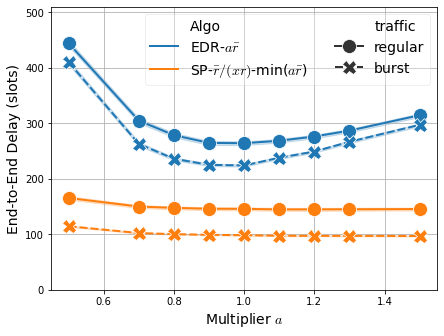

In [13]:
hue_order = []
for opt in [7,45,46,49]:
# for opt in [7,45]:
# for opt in [7]:
    hue_order.append(lgds[opt])

# postfix = ['burst', 'regular'][1]
postfix=''

# key = 'delay'
# key = 'delivery'
key = 'e2e'


item_dict={
    'delay': 'src_delay_mean',
    'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
#     'delay': 'src_delay_max',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_max',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 300, #160,
    'delivery': 1.05,
    'e2e': 510
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

# df_tmp = df[df['traffic']==postfix]
df_tmp = df[df['opt'].isin([7, 45])]
df_tmp.loc[df_tmp['opt']==7,'Algo'] = r'EDR-$a\bar{r}$'
df_tmp.loc[df_tmp['opt']==45,'Algo'] = r'SP-$\bar{r}/(xr)$-min($a\bar{r}$)'
hue_order = [r'EDR-$a\bar{r}$', r'SP-$\bar{r}/(xr)$-min($a\bar{r}$)']
# hue_order = [r'EDR-$a\bar{r}$']

# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="mpx", y=item, 
             hue="Algo", 
             hue_order=hue_order,
             data=df_tmp, 
#              ci=95,
#              errorbar="ci",
             err_style="band",
#              err_style="bars", 
             errorbar=("se", 2),
             linewidth=2.0, 
             palette="tab10", 
#              style="Algo",
             style="traffic",
             markers=True,
             markersize=14,
             ax=ax,
                 )
L = ax.legend(
    fontsize=14,
    framealpha=0.3,
    ncol=2,
#     loc='upper center',
)

# ax.get_legend().remove()
# add_patch(L)

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
ax.set_ylim([0, ymax])
ax.grid(True)
# ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
ax.set_xlabel(r'Multiplier $a$', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_{}_sp_mpx_{}.pdf'.format(csvfile.split('.')[0], key, postfix)
# fname = '../fig/SP_BP_{}_{}_sp_mpx.pdf'.format(csvfile.split('.')[0], key, postfix)
fname = '../fig/SP_BP_{}_{}_sp_mpx.pdf'.format("test_data_poisson_10_T_1000_ir_1", key, postfix)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
# fig.savefig(fname,
#             dpi=300,  # facecolor='w', edgecolor='w',
#             orientation='portrait',
#             format='pdf')


## Mobility 

In [5]:
gtype='poisson'
T=1000
opts_dict = [[7,107],[5,105]]
link_rate = 26.0
radius=1.0

df = pd.DataFrame([])
for postfix in ['mobility']:
    for radius in [0.0, 1.0]:
        for opts in opts_dict:
            opts_txt = [str(i) for i in opts]
            opts_txt = '-'.join(opts_txt)
            csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}.csv".format(gtype, T, radius, opts_txt,link_rate,postfix)
            fullpath = os.path.join(outdir, csvfile)
            df_res = pd.read_csv(fullpath, index_col=None)
            df_res['Bias_Update'] = ''
            df_res.loc[df_res['opt']>=100, 'Bias_Update'] = 'Ideal'
            df_res.loc[df_res['opt']<100, 'Bias_Update'] = 'Neighbor'
            df_res['opt'] = df_res['opt'] % 100
            df = pd.concat([df, df_res], ignore_index=True)
            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item
    
df['e2e2'] = df['src_delay_mean'] * df['delivery_mean'] + T * (1.0-df['delivery_mean'])

df.sort_values('opt', inplace=True)
df

,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,num_flows,...,est_delay_max,est_delay_std,delivery_mean,delivery_max,delivery_std,active_links,runtime,f_case,Bias_Update,e2e2
15675,poisson_graph_seed517_m8_n100_f24.mat,517,100,8,1000,0.0,12.546032,5,SP-$\bar{r}/(xr)$,48,...,185.647727,48.237258,0.944154,1.0,0.055327,292.298,86.332266,9.0,Ideal,108.507365
23518,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,38.212500,5,SP-$\bar{r}/(xr)$,32,...,306.662587,92.073027,0.804416,1.0,0.202864,258.472,129.285152,0.0,Neighbor,247.435482
23517,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,38.212500,5,SP-$\bar{r}/(xr)$,32,...,306.662587,92.073027,0.804416,1.0,0.202864,258.472,129.285152,0.0,Neighbor,247.435482
23516,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,38.212500,5,SP-$\bar{r}/(xr)$,32,...,306.662587,92.073027,0.804416,1.0,0.202864,258.472,129.285152,0.0,Neighbor,247.435482
23515,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,38.212500,5,SP-$\bar{r}/(xr)$,32,...,306.662587,92.073027,0.804416,1.0,0.202864,258.472,129.285152,0.0,Neighbor,247.435482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20904,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,34.420732,7,EDR-$\bar{r}$,31,...,203.024870,55.439710,0.923026,1.0,0.112068,264.849,119.085299,7.0,Neighbor,125.889293
20905,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,34.420732,7,EDR-$\bar{r}$,31,...,203.024870,55.439710,0.923026,1.0,0.112068,264.849,119.085299,7.0,Neighbor,125.889293
20906,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,34.420732,7,EDR-$\bar{r}$,31,...,203.024870,55.439710,0.923026,1.0,0.112068,264.849,119.085299,7.0,Neighbor,125.889293
20908,poisson_graph_seed514_m8_n100_f21.mat,514,100,8,1000,1.0,34.420732,7,EDR-$\bar{r}$,31,...,203.024870,55.439710,0.923026,1.0,0.112068,264.849,119.085299,7.0,Neighbor,125.889293


In [7]:
df.groupby(['Algo','cf_radius','Bias_Update']).std()

seed  num_nodes    m    T  \
Algo              cf_radius Bias_Update                                  
EDR-$\bar{r}$     0.0       Ideal        5.674595        0.0  0.0  0.0   
                            Neighbor     5.674595        0.0  0.0  0.0   
                  1.0       Ideal        5.674595        0.0  0.0  0.0   
                            Neighbor     5.674595        0.0  0.0  0.0   
SP-$\bar{r}/(xr)$ 0.0       Ideal        5.674595        0.0  0.0  0.0   
                            Neighbor     5.674595        0.0  0.0  0.0   
                  1.0       Ideal        5.674595        0.0  0.0  0.0   
                            Neighbor     5.674595        0.0  0.0  0.0   

                                         cf_degree  opt  num_flows    z  \
Algo              cf_radius Bias_Update                                   
EDR-$\bar{r}$     0.0       Ideal         0.882683  0.0   5.928457  0.0   
                            Neighbor      0.882683  0.0   5.928457  0.0   
                  1.0       Ideal         4.813642  0.0   5.928457  0.0   
                            Neighbor      4.813642  0.0   5.928457  0.0   
SP-$\bar{r}/(xr)$ 0.0       Ideal         0.882683  0.0   5.928457  0.0   
                            Neighbor      0.882683  0.0   5.928457  0.0   
                  1.0       Ideal         4.813642  0.0   5.928457  0.0   
                            Neighbor      4.813642  0.0   5.928457  0.0   

                                         src_delay_raw  src_delay_mean  ...  \
Algo              cf_radius Bias_Update                                 ...   
EDR-$\bar{r}$     0.0       Ideal            66.424487       25.189375  ...   
                            Neighbor         74.802581       26.999994  ...   
                  1.0       Ideal           104.630293       40.381891  ...   
                            Neighbor        106.858956       38.044524  ...   
SP-$\bar{r}/(xr)$ 0.0       Ideal            36.888591       15.865493  ...   
                            Neighbor         78.341159       27.466284  ...   
                  1.0       Ideal            69.898739       31.300319  ...   
                            Neighbor         92.556086       31.744355  ...   

                                         est_delay_mean  est_delay_max  \
Algo              cf_radius Bias_Update                                  
EDR-$\bar{r}$     0.0       Ideal             26.161994      90.195349   
                            Neighbor          31.447135      96.545845   
                  1.0       Ideal             45.875248     103.551803   
                            Neighbor          46.490256      91.940816   
SP-$\bar{r}/(xr)$ 0.0       Ideal             15.937249      62.238346   
                            Neighbor          35.214290     100.874470   
                  1.0       Ideal             32.592021     101.313047   
                            Neighbor          38.553747      93.069139   

                                         est_delay_std  delivery_mean  \
Algo              cf_radius Bias_Update                                 
EDR-$\bar{r}$     0.0       Ideal            25.342202       0.044923   
                            Neighbor         28.051076       0.062409   
                  1.0       Ideal            33.166782       0.087462   
                            Neighbor         31.439550       0.091365   
SP-$\bar{r}/(xr)$ 0.0       Ideal            16.166224       0.028330   
                            Neighbor         32.331686       0.074452   
                  1.0       Ideal            29.413597       0.061109   
                            Neighbor         31.505819       0.078262   

                                         delivery_max  delivery_std  \
Algo              cf_radius Bias_Update                               
EDR-$\bar{r}$     0.0       Ideal            0.002184      0.046706   
                            Neighbor         0.002203      0.059493   
      

In [29]:
output_csv = os.path.join(outdir, 'SP_BP_{}_{}_sp_mobility.csv'.format(csvfile.split('.')[0], key, postfix))
df.to_csv(output_csv, index=False)
# df = pd.read_csv(output_csv, index_col=False)

../fig/SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_sp_mobility.pdf


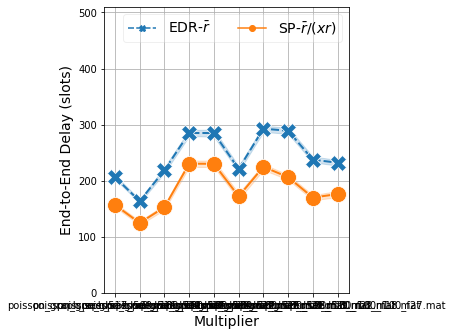

In [16]:
hue_order = []
# for opt in [7,45,46,49]:
for opt in [7,5]:
    hue_order.append(lgds[opt])

postfix = 'mobility'

# key = 'delay'
# key = 'delivery'
key = 'e2e'


item_dict={
    'delay': 'src_delay_mean',
    'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
#     'delay': 'src_delay_max',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_max',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 300, #160,
    'delivery': 1.05,
    'e2e': 510
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

# df_tmp = df[df['traffic']==postfix]
df_tmp = df[df['opt'].isin([7, 5])]
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="filename", y=item, 
             hue="Algo", 
             hue_order=hue_order,
             data=df_tmp, 
             ci=95,
             err_style="band",
             linewidth=2.0, 
             palette="tab10", 
             style="Algo",
#              style="traffic",
             markers=True,
             markersize=16,
             ax=ax,
                 )
L = ax.legend(
    fontsize=14,
    framealpha=0.3,
    ncol=2,
#     loc='upper center',
)

# ax.get_legend().remove()
# add_patch(L)

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
ax.set_ylim([0, ymax])
ax.grid(True)
# ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
ax.set_xlabel('Multiplier', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_{}_sp_mpx_{}.pdf'.format(csvfile.split('.')[0], key, postfix)
fname = '../fig/SP_BP_{}_{}_sp_{}.pdf'.format(csvfile.split('.')[0], key, postfix)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


## MLP vs GNN

In [5]:
gtype='poisson'
T=1000
opts_dict = [[5],[6],[46],[35],[45]]
link_rate = 26.0
radius=1.0

df = pd.DataFrame([])
for postfix in ['mixed_raw_mlp']:
    for radius in [0.0, 1.0]:
        for opts in opts_dict:
            opts_txt = [str(i) for i in opts]
            opts_txt = '-'.join(opts_txt)
            csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}.csv".format(gtype, T, radius, opts_txt,link_rate,postfix)
            fullpath = os.path.join(outdir, csvfile)
            df_res = pd.read_csv(fullpath, index_col=None)
            df_res['Bias_Update'] = ''
            df_res.loc[df_res['opt']>=100, 'Bias_Update'] = 'Ideal'
            df_res.loc[df_res['opt']<100, 'Bias_Update'] = 'Neighbor'
            df_res['opt'] = df_res['opt'] % 100
            df = pd.concat([df, df_res], ignore_index=True)
            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item + '-MLP'

values = {"src_delay_raw": T}
df.fillna(value=values, inplace=True)
df['e2e2'] = df['src_delay_raw'] * df['delivery_raw'] + T * (1.0-df['delivery_raw'])

df.sort_values('opt', inplace=True)
df_mlp = df

In [61]:
df.columns
# df_mlp
# df[]
# df[['filename', 'seed', 'num_nodes', 'm', 'T', 'cf_radius', 'cf_degree',
#        'opt', 'Algo', 'num_flows', 'z', 'src_delay_raw', 'src_delay_mean',
#        'src_delay_max', 'src_delay_std', 'est_delay_mean', 'est_delay_max',
#        'est_delay_std', 'delivery_mean']]

Index(['filename', 'seed', 'num_nodes', 'm', 'T', 'cf_radius', 'cf_degree',
       'opt', 'Algo', 'num_flows', 'z', 'src_delay_raw', 'est_delay_raw',
       'delivery_raw', 'active_links', 'runtime', 'f_case', 'cnt_out_raw',
       'cnt_in_raw', 'flow_rate', 'cutoff', 'src', 'dst', 'Bias_Update',
       'e2e2'],
      dtype='object')

In [6]:
opts_dict = [[0], [60,50],[7,27],[57,67],[5,25],[6,26],[9,29],[39,49],[4,44],[35,45]]
# opts_dict = [[0],[36,46],[25,45],[35,55],[7]]

df = pd.DataFrame([])
for postfix in ['mixed_raw']:
    for radius in [0.0, 1.0]:
        for opts in opts_dict:
            opts_txt = [str(i) for i in opts]
            opts_txt = '-'.join(opts_txt)
            csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}.csv".format(gtype, T, radius, opts_txt,link_rate,postfix)
            fullpath = os.path.join(outdir, csvfile)
            if not os.path.isfile(fullpath):
                continue
            df_res = pd.read_csv(fullpath, index_col=None)
            df_res['Bias_Update'] = ''
            df_res.loc[df_res['opt']>=100, 'Bias_Update'] = 'Ideal'
            df_res.loc[df_res['opt']<100, 'Bias_Update'] = 'Neighbor'
            df_res['opt'] = df_res['opt'] % 100
            df = pd.concat([df, df_res], ignore_index=True)
            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item

values = {"src_delay_raw": T}
df.fillna(value=values, inplace=True)
# df.rename(columns={
#     "delivery_mean": "delivery_raw",
# }, inplace=True)
df['e2e2'] = df['src_delay_raw'] * df['delivery_raw'] + T * (1.0-df['delivery_raw'])
# df['e2e2'] = df['src_delay_mean'] * df['delivery_mean'] + T * (1.0-df['delivery_mean'])

df.sort_values('opt', inplace=True)
df

,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,f_case,...,cnt_out_raw,cnt_in_raw,flow_rate,cutoff,src,dst,active_links,runtime,Bias_Update,e2e2
0,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,0.0,13.366154,0,BP,0.0,...,106.0,747.0,0.721690,-1.0,78.0,25.0,323.665,94.667875,Neighbor,901.313209
34110,poisson_graph_seed507_m8_n90_f18.mat,507,90,8,1000,1.0,30.981949,0,BP,2.0,...,0.0,268.0,9.117895,30.0,54.0,66.0,276.571,95.701181,Neighbor,1000.000000
34111,poisson_graph_seed507_m8_n90_f18.mat,507,90,8,1000,1.0,30.981949,0,BP,2.0,...,0.0,245.0,8.520881,30.0,12.0,86.0,276.571,95.701181,Neighbor,1000.000000
34112,poisson_graph_seed507_m8_n90_f18.mat,507,90,8,1000,1.0,30.981949,0,BP,2.0,...,0.0,369.0,13.145611,30.0,15.0,9.0,276.571,95.701181,Neighbor,1000.000000
34113,poisson_graph_seed507_m8_n90_f18.mat,507,90,8,1000,1.0,30.981949,0,BP,2.0,...,0.0,919.0,0.901137,-1.0,73.0,88.0,276.571,95.701181,Neighbor,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124188,poisson_graph_seed509_m8_n70_f13.mat,509,70,8,1000,1.0,31.429907,67,EDR-$\bar{r}$-HOL,4.0,...,408.0,408.0,14.047028,30.0,4.0,11.0,175.066,85.366632,Neighbor,283.164216
124189,poisson_graph_seed509_m8_n70_f13.mat,509,70,8,1000,1.0,31.429907,67,EDR-$\bar{r}$-HOL,4.0,...,681.0,717.0,0.712012,-1.0,17.0,18.0,175.066,85.366632,Neighbor,137.573036
106083,poisson_graph_seed500_m8_n90_f22.mat,500,90,8,1000,1.0,46.397394,67,EDR-$\bar{r}$-HOL,2.0,...,522.0,522.0,16.578849,30.0,81.0,66.0,195.305,94.410769,Neighbor,209.681992
106081,poisson_graph_seed500_m8_n90_f22.mat,500,90,8,1000,1.0,46.397394,67,EDR-$\bar{r}$-HOL,2.0,...,852.0,870.0,0.883645,-1.0,20.0,43.0,195.305,94.410769,Neighbor,153.402597


In [7]:
csvfile = os.path.join(outdir, 'SP_BP_test_data_poisson_10_T_1000_ir_0_e2e_sp_algorithms_mixed.csv')
df_0 = pd.read_csv(csvfile, index_col=False)
df = pd.concat([df, df_0, df_mlp], ignore_index=True)

In [6]:
postfix='mixed_raw'

output_csv = os.path.join(outdir, 'SP_BP_{}ir_01_{}_sp_algorithms_{}_mlp_vs_gnn.csv'.format("test_data_poisson_10_T_1000_", 'e2e', postfix))
# df.to_csv(output_csv, index=False)
df = pd.read_csv(output_csv, index_col=False)

# csvfile = os.path.join(outdir, 'SP_BP_test_data_poisson_10_T_1000_ir_0_e2e_sp_algorithms_mixed.csv')
# df_0 = pd.read_csv(csvfile, index_col=False)

../fig/SP_BP_test_data_poisson_10_T_1000_ir_1_delivery_algos_mixed_bursty_mlp.pdf


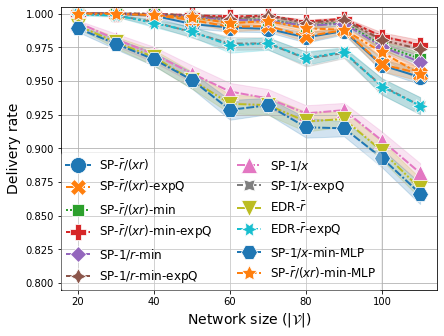

In [16]:
postfix='mixed' # comment me for mlp vs gnn

hue_order = []
# for opt in [7]:
#     hue_order.append(lgds[opt])
# for opt in [6,5,45]:
#     hue_order.append(lgds[opt])
# # for opt in [7]:
# #     hue_order.append(lgds[opt])
# for opt in [6,46,5,45]:
#     hue_order.append(lgds[opt]+'-MLP')
for opt in [5,25,45,35,49,39,6,26,7,27]:
    hue_order.append(lgds[opt])
for opt in [46,45]:
    hue_order.append(lgds[opt]+'-MLP')

# key = 'delay'
key = 'delivery'
# key = 'e2e'
cf_radius = 1.0
# cf_radius = 0.0
# subtypes = 'all' 
# subtypes = 'stream' 
subtypes = 'bursty'

df_tmp = df[df['cf_radius']==cf_radius]
# df_tmp = df_tmp[df_tmp['opt'].isin([0,7,27,5])]

if subtypes == 'stream':
    df_tmp = df_tmp[df_tmp['cutoff'] == -1]
elif subtypes == 'bursty':
    df_tmp = df_tmp[df_tmp['cutoff'] != -1]

df_tmp = df_tmp[df_tmp['Algo'].isin(hue_order)]

item_dict={
#     'delay': 'src_delay_mean',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
    'delay': 'src_delay_raw',
    'delivery': 'delivery_raw',
#     'e2e': 'est_delay_max',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 1000, #160,
    'delivery': 1.005,
    'e2e': 1000
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="num_nodes", y=item, 
             hue="Algo", 
#              hue="cf_radius", 
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$', r'SP-$\bar{r}/r$'],
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$'],
             hue_order=hue_order,
             data=df_tmp, 
#              ci=95,
             err_style="band",
             linewidth=2.0, 
#              errorbar=('se',2),
             errorbar=('ci',95),
             palette="tab10", 
#             style="cf_radius",
             style="Algo",
             style_order=hue_order,
             markers=True,
             markersize=16,
             ax=ax,
             # alpha=0.6,
             # mfc="None", 
             # mew=2, 
             # mec='black',
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(
    fontsize=12,
    framealpha=0.3,
    ncol=2,
    loc='lower left',
#     loc='upper left',
#     bbox_to_anchor=(1.0,0.57),
#     bbox_to_anchor=(1.0,0.48),
    borderaxespad=0.,
)

# if key != "e2e":
#     ax.get_legend().remove()
# add_patch(L)
# ax.get_legend().remove()

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
# ax.set_ylim([0, 510])
# ax.set_ylim([0, 400])
ax.set_ylim([0.795, ymax])
# ax.set_ylim([0, ymax])
ax.grid(True)
ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
# ax.set_ylabel('End-to-End Delay (time slots)', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_cali_{}.pdf'.format(csvfile.split('.')[0], key)
# fname = '../fig/SP_BP_{}_{}.pdf'.format(csvfile.split('.')[0], key)
fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}_{}_mlp.pdf'.format('test_data_poisson_10_T_1000_', cf_radius, key, postfix, subtypes)
# fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}_{}_mlp_vs_gnn.pdf'.format('test_data_poisson_10_T_1000_', cf_radius, key, subtypes, postfix)
# fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}_{}_all.pdf'.format(csvfile.split('ir')[0], cf_radius, key, postfix, subtypes)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


## Full Comparison

In [5]:
gtype='poisson_d12'
T=1000
# postfix='regular'
# postfix='burst'
postfix='mixed'
link_rate = 26.0


In [6]:
# regular
# opts_dict = [[0,1,5,6,7,9],[20,21,25,26,27,29],[35,36,39],[45,46,49],[50,55,57],[60,65,67]]
# mixed
# opts_dict = [[0],[7],[1,4,5],[6],[26],[50],[60],[47,57],[67,77],[35,55],[36,46],[37,51],[44],[39,49],[25,45]] 
opts_dict = [[0], [50,60], [7,27], [57,67], [5,25], [6,26], [9,29], [39,49], [4,44], [35,45]]

df = pd.DataFrame([])
for radius in [0.0, 1.0]:
# for radius in [1.0]:
    for opts in opts_dict:
        opts_txt = [str(i) for i in opts]
        opts_txt = '-'.join(opts_txt)
        csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}_raw.csv".format(gtype, T, radius, opts_txt,link_rate,postfix)
#         csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}_raw_light.csv".format(gtype, T, radius, opts_txt,link_rate,postfix)
        fullpath = os.path.join(outdir, csvfile)
        if not os.path.isfile(fullpath):
            print("missing {}".format(fullpath))
            continue
        df_res = pd.read_csv(fullpath, index_col=None)
        df_res['Bias_Update'] = ''
        df_res.loc[df_res['opt']>=100, 'Bias_Update'] = 'Ideal'
        df_res.loc[df_res['opt']<100, 'Bias_Update'] = 'Neighbor'
        df_res['opt'] = df_res['opt'] % 100
        df = pd.concat([df, df_res], ignore_index=True)            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item

values = {"src_delay_raw": T}
df.fillna(value=values, inplace=True)
df['e2e2'] = df['src_delay_raw'] * df['delivery_raw'] + T * (1.0-df['delivery_raw'])

# df = df.groupby(['filename','seed','cf_radius','opt','f_case','Algo','Bias_Update']).mean().reset_index()

# df.sort_values('opt', inplace=True)
df

,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,f_case,...,cnt_out_raw,cnt_in_raw,flow_rate,cutoff,src,dst,active_links,runtime,Bias_Update,e2e2
0,poisson_graph_seed500_m12_n100_f17.mat,500,100,12,1000,0.0,21.156863,0,BP,0,...,381,747,0.721690,-1,78,25,509.022,157.067655,Neighbor,553.771225
1,poisson_graph_seed500_m12_n100_f17.mat,500,100,12,1000,0.0,21.156863,0,BP,0,...,277,545,0.585857,-1,90,33,509.022,157.067655,Neighbor,553.161363
2,poisson_graph_seed500_m12_n100_f17.mat,500,100,12,1000,0.0,21.156863,0,BP,0,...,12,202,6.810894,30,4,28,509.022,157.067655,Neighbor,982.995033
3,poisson_graph_seed500_m12_n100_f17.mat,500,100,12,1000,0.0,21.156863,0,BP,0,...,111,921,28.264393,30,47,95,509.022,157.067655,Neighbor,929.323663
4,poisson_graph_seed500_m12_n100_f17.mat,500,100,12,1000,0.0,21.156863,0,BP,0,...,0,380,0.373201,-1,61,88,509.022,157.067655,Neighbor,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971503,poisson_graph_seed512_m12_n80_f12.mat,512,80,12,1000,1.0,59.198880,45,SP-$\bar{r}/(xr)$-min,9,...,596,604,20.534615,30,37,70,304.461,102.416332,Neighbor,212.145669
971504,poisson_graph_seed512_m12_n80_f12.mat,512,80,12,1000,1.0,59.198880,45,SP-$\bar{r}/(xr)$-min,9,...,723,723,23.670335,30,51,14,304.461,102.416332,Neighbor,8.123098
971505,poisson_graph_seed512_m12_n80_f12.mat,512,80,12,1000,1.0,59.198880,45,SP-$\bar{r}/(xr)$-min,9,...,986,987,32.102554,30,59,23,304.461,102.416332,Neighbor,16.237927
971506,poisson_graph_seed512_m12_n80_f12.mat,512,80,12,1000,1.0,59.198880,45,SP-$\bar{r}/(xr)$-min,9,...,528,531,0.498261,-1,3,75,304.461,102.416332,Neighbor,29.859033


In [94]:
# postfix='regular'
# output_csv = os.path.join("../out", "SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_sp_algorithms_regular.csv")
# postfix='burst'
output_csv = os.path.join(outdir, 'SP_BP_test_data_{}_10{}ir_01_{}_sp_algorithms_{}_raw.csv'.format("poisson_d12","_T_1000_", 'e2e', postfix))
df.to_csv(output_csv, index=False)
# df = pd.read_csv(output_csv, index_col=False)

In [42]:
# output_csv = os.path.join("../out2", "SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_sp_algorithms_regular.csv")
# df2 = pd.read_csv(output_csv, index_col=False)
# df2['e2e2'] = df2['src_delay_mean'] * df2['delivery_mean'] + T * (1.0-df2['delivery_mean'])
# df2.groupby(['opt','cf_radius']).mean()

In [95]:
# df.loc[df['opt']==37, 'Algo'] = lgds[27]
# df.loc[df['opt']==47, 'Algo'] = lgds[7]
avgs = df.groupby(['opt','cf_radius','cutoff']).mean()
avgs[["delivery_raw","e2e2"]]
# df2 = df.groupby(['filename','seed','cf_radius','opt','f_case','Algo','Bias_Update']).mean().reset_index()
# df2.columns

delivery_raw        e2e2
opt cf_radius cutoff                          
0   0.0       -1          0.222063  814.978900
               30         0.269752  773.188154
    1.0       -1          0.141427  878.994674
               30         0.152629  868.149115
4   0.0       -1          0.088980  927.705049
...                            ...         ...
60  1.0        30         0.234157  832.244649
67  0.0       -1          0.974000   52.667934
               30         0.997747   73.559099
    1.0       -1          0.928705  150.435002
               30         0.986811  208.033334

[76 rows x 2 columns]

In [114]:
# csvfile
# set(df.columns) - set(df2.columns)
# df.columns
# lgds

../fig/SP_BP_test_data_poisson_d12_10_T_1000_ir_1_delivery_algos_mixed_stream_4algos2.pdf


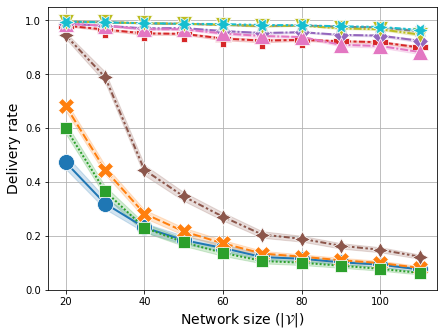

In [109]:
hue_order = []
for opt in [0,50,60,7,27,57,67,5,25,45]:
# for opt in [0,7,27,5]:
# for opt in [5,25,45,35,49,39,6,26,7,27]:
    hue_order.append(lgds[opt])

# key = 'delay'
key = 'delivery'
# key = 'e2e'
cf_radius = 1.0
# cf_radius = 0.0
# subtypes = 'all' 
subtypes = 'stream' 
# subtypes = 'bursty'

df_tmp = df[df['cf_radius']==cf_radius]
# df_tmp = df_tmp[df_tmp['opt'].isin([0,7,27,5])]

if subtypes == 'stream':
    df_tmp = df_tmp[df_tmp['cutoff'] == -1]
elif subtypes == 'bursty':
    df_tmp = df_tmp[df_tmp['cutoff'] != -1]

df_tmp = df_tmp[df_tmp['Algo'].isin(hue_order)]

item_dict={
#     'delay': 'src_delay_mean',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
    'delay': 'src_delay_raw',
    'delivery': 'delivery_raw',
#     'e2e': 'est_delay_max',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 1000, #160,
    'delivery': 1.05,
    'e2e': 1000
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="num_nodes", y=item, 
             hue="Algo", 
#              hue="cf_radius", 
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$', r'SP-$\bar{r}/r$'],
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$'],
             hue_order=hue_order,
             data=df_tmp, 
#              ci=95,
             err_style="band",
             linewidth=2.0, 
#              errorbar=('se',2),
             errorbar=('ci',95),
             palette="tab10", 
#             style="cf_radius",
             style="Algo",
             style_order=hue_order,
             markers=True,
             markersize=16,
             ax=ax,
             # alpha=0.6,
             # mfc="None", 
             # mew=2, 
             # mec='black',
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(
    fontsize=12,
    framealpha=0.3,
    ncol=2,
#     loc='lower left',
    loc='center right',
#     bbox_to_anchor=(1.0,0.57),
    bbox_to_anchor=(1.0,0.48),
    borderaxespad=0.,
)

if key != 'e2e':
    ax.get_legend().remove()
# add_patch(L)

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
# ax.set_ylim([0, 510])
# ax.set_ylim([0, 400])
# ax.set_ylim([0.795, ymax])
ax.set_ylim([0, ymax])
ax.grid(True)
ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
# ax.set_ylabel('End-to-End Delay (time slots)', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_cali_{}.pdf'.format(csvfile.split('.')[0], key)
# fname = '../fig/SP_BP_{}_{}.pdf'.format(csvfile.split('.')[0], key)
# fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}.pdf'.format('test_data_poisson_10_T_1000_', cf_radius, key, postfix)
fname = '../fig/SP_BP_test_data_{}_10_T_1000_ir_{:.0f}_{}_algos_{}_{}_4algos2.pdf'.format(gtype, cf_radius, key, postfix, subtypes)
# fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}_{}_all.pdf'.format(csvfile.split('ir')[0], cf_radius, key, postfix, subtypes)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


## Burst traffic

In [22]:
gtype='poisson'
T=1000
opts_dict = [[0,1,5,6,7],[5,6,9],[25,26,29],[35,36,39],[45,46,49],[7,27,37,47],[50,55,57],[60,65,67]]
link_rate = 26.0
postfix='burst'

df = pd.DataFrame([])
for radius in [0.0, 1.0]:
    for opts in opts_dict:
        opts_txt = [str(i) for i in opts]
        opts_txt = '-'.join(opts_txt)
        csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}.csv".format(gtype, T, radius, opts_txt,link_rate)
        fullpath = os.path.join(outdir, csvfile)
        if not os.path.isfile(fullpath):
            csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_burst.csv".format(gtype, T, radius, opts_txt,link_rate, postfix)
            fullpath = os.path.join(outdir, csvfile)
        df_res = pd.read_csv(fullpath, index_col=None)
        if opts == [0,1,5,6,7]:
            df_res = df_res[df_res['opt'].isin([0,1])]
        df = pd.concat([df, df_res], ignore_index=True)            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item
    
df['e2e2'] = df['src_delay_mean'] * df['delivery_mean'] + T * (1.0-df['delivery_mean'])

df.sort_values('opt', inplace=True)
df

,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,num_flows,...,est_delay_mean,est_delay_max,est_delay_std,delivery_mean,delivery_max,delivery_std,active_links,runtime,f_case,e2e2
0,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,0.0,13.366154,0,BP,42,...,896.605101,955.834320,149.077705,0.065943,0.771429,0.166267,324.314,88.909954,0.0,949.954554
654433,poisson_graph_seed512_m8_n50_f12.mat,512,50,8,1000,1.0,27.733333,0,BP,20,...,903.107964,957.727273,90.516276,0.060272,0.435737,0.113014,149.419,37.198313,2.0,948.688813
654432,poisson_graph_seed512_m8_n50_f12.mat,512,50,8,1000,1.0,27.733333,0,BP,20,...,903.107964,957.727273,90.516276,0.060272,0.435737,0.113014,149.419,37.198313,2.0,948.688813
654431,poisson_graph_seed512_m8_n50_f12.mat,512,50,8,1000,1.0,27.733333,0,BP,20,...,903.107964,957.727273,90.516276,0.060272,0.435737,0.113014,149.419,37.198313,2.0,948.688813
654430,poisson_graph_seed512_m8_n50_f12.mat,512,50,8,1000,1.0,27.733333,0,BP,20,...,903.107964,957.727273,90.516276,0.060272,0.435737,0.113014,149.419,37.198313,2.0,948.688813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620550,poisson_graph_seed524_m8_n90_f17.mat,524,90,8,1000,0.0,12.941581,67,EDR-$\bar{r}$-HOL,40,...,60.380093,154.123377,37.299098,1.000000,1.000000,0.000000,38.027,34.613161,9.0,60.380093
620549,poisson_graph_seed524_m8_n90_f17.mat,524,90,8,1000,0.0,12.941581,67,EDR-$\bar{r}$-HOL,40,...,60.380093,154.123377,37.299098,1.000000,1.000000,0.000000,38.027,34.613161,9.0,60.380093
620548,poisson_graph_seed524_m8_n90_f17.mat,524,90,8,1000,0.0,12.941581,67,EDR-$\bar{r}$-HOL,40,...,60.380093,154.123377,37.299098,1.000000,1.000000,0.000000,38.027,34.613161,9.0,60.380093
620546,poisson_graph_seed524_m8_n90_f17.mat,524,90,8,1000,0.0,12.941581,67,EDR-$\bar{r}$-HOL,40,...,60.380093,154.123377,37.299098,1.000000,1.000000,0.000000,38.027,34.613161,9.0,60.380093


In [78]:
postfix='burst'
output_csv = os.path.join(outdir, 'SP_BP_{}_{}_sp_algorithms_{}.csv'.format(csvfile.split('.')[0], key, postfix))
# df.to_csv(output_csv, index=False)
df = pd.read_csv(output_csv, index_col=False)

In [23]:
df.groupby(['opt']).mean()

,seed,num_nodes,m,T,cf_radius,cf_degree,num_flows,z,src_delay_raw,src_delay_mean,...,est_delay_mean,est_delay_max,est_delay_std,delivery_mean,delivery_max,delivery_std,active_links,runtime,f_case,e2e2
opt,,,,,,,,,,,,,,,,,,,,,
0,509.783938,77.713443,8.0,1000.0,0.5,24.475982,34.647320,0.100000,238.911558,233.866573,...,849.282881,954.604847,178.424943,0.130734,0.795066,2.104491e-01,250.596475,67.125315,4.512715,899.355442
1,509.783938,77.713443,8.0,1000.0,0.5,24.475982,34.647320,0.100000,257.793008,249.014842,...,800.578307,951.928121,211.899428,0.199874,0.881900,2.512261e-01,250.165472,67.067957,4.512715,850.499752
5,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,59.587415,59.587415,...,59.945154,141.341525,40.408587,0.999567,1.000000,1.415121e-03,34.072213,26.701212,4.503654,59.979832
6,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,126.959750,129.015758,...,371.610036,906.732745,294.584640,0.689302,0.999964,2.934699e-01,180.422705,54.961112,4.503654,395.121313
7,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,87.293935,87.514164,...,141.123168,465.705382,120.205589,0.933053,0.999998,9.182086e-02,142.586960,48.766845,4.503654,146.661214
9,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,64.571803,64.572761,...,64.745135,144.730278,41.046176,0.999754,1.000000,4.098628e-04,35.753541,27.676619,4.503654,64.786545
25,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,59.391978,59.391978,...,59.392076,136.935235,40.075361,1.000000,1.000000,8.824973e-07,30.296806,23.153556,4.503654,59.392107
26,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,117.096929,117.101278,...,119.102276,357.686973,95.250643,0.996315,1.000000,1.015568e-02,93.061227,33.902774,4.503654,120.064350
27,509.895025,77.633564,8.0,1000.0,0.5,24.434928,31.213077,0.038462,83.479393,83.496446,...,85.179919,220.622284,60.944538,0.997292,1.000000,5.901844e-03,64.786033,34.335713,4.503654,85.739926


../fig/SP_BP_test_data_poisson_10_T_1000_ir_1_e2e_algos_burst.pdf


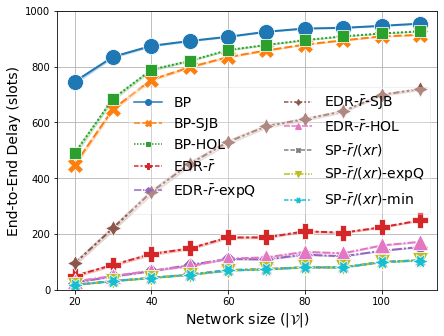

In [25]:
hue_order = []
for opt in [0,50,60,7,27,57,67,5,25,45]:
# for opt in [6,16,26]:
    hue_order.append(lgds[opt])


# key = 'delay'
# key = 'delivery'
key = 'e2e'


item_dict={
    'delay': 'src_delay_mean',
    'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
#     'delay': 'src_delay_max',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_max',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 300, #160,
    'delivery': 1.05,
    'e2e': 1000
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

df_tmp = df[df['cf_radius']==1.0]
df_tmp = df_tmp[df_tmp['Algo'].isin(hue_order)]
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="num_nodes", y=item, 
             hue="Algo", 
#              hue="cf_radius", 
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$', r'SP-$\bar{r}/r$'],
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$'],
             hue_order=hue_order,
             data=df_tmp, 
             ci=95,
             err_style="band",
             linewidth=2.0, 
             palette="tab10", 
#             style="cf_radius",
             style="Algo",
             style_order=hue_order,
             markers=True,
             markersize=16,
             ax=ax,
             # alpha=0.6,
             # mfc="None", 
             # mew=2, 
             # mec='black',
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(
    fontsize=14,
    framealpha=0.3,
    ncol=2,
#     loc='upper center',
)

# ax.get_legend().remove()
# add_patch(L)

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
# ax.set_ylim([0, 510])
# ax.set_ylim([0, 350])
ax.set_ylim([0, ymax])
ax.grid(True)
ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
# ax.set_ylabel('End-to-End Delay (time slots)', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_cali_{}.pdf'.format(csvfile.split('.')[0], key)
# fname = '../fig/SP_BP_{}_{}.pdf'.format(csvfile.split('.')[0], key)
fname = '../fig/SP_BP_{}_{}_algos_{}.pdf'.format(csvfile.split('.')[0], key, postfix)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


## Traffic load

In [86]:
gtype='poisson'
T=1000
postfix='regular'
# postfix='mixed'
link_rate = 26.0

In [87]:
# load '1' '5' '61' '71' '47' '57' '67' '77' '35' 
# opts_dict = [[0],[50],[60],[5],[25],[35],[37],[47],[57],[67],[46],[36],[49],[39]]
opts_dict = [[0],[50],[60],[5],[25],[35],[45],[7],[27],[37],[47],[57],[67],[6],[26],[46],[36],[9],[49],[39]]

radius = 1.0
df = pd.DataFrame([])
for opts in opts_dict:
    opts_txt = [str(i) for i in opts]
    opts_txt = '-'.join(opts_txt)
#     for loadstr in ['0.6_3.0','3.0_6.1']: # , '0.3_2.9'
    for loadstr in ['0.1_3.0','3.0_12.1']: 
        csvfile = "test_data_{}_10_T_{}_ir_{:.1f}_opts_{}_link-{}_{}_load_{}.csv".format(
            gtype, T, radius, opts_txt,link_rate,postfix,loadstr)
        fullpath = os.path.join(outdir, csvfile)
        if not os.path.isfile(fullpath):
            print("missing {}".format(fullpath))
            continue
        df_res = pd.read_csv(fullpath, index_col=None)
        df = pd.concat([df, df_res], ignore_index=True)            

df['Algo'] = ''
for i, item in lgds.items():
    df.loc[df['opt']==i, 'Algo'] = item
    
df['e2e2'] = df['src_delay_mean'] * df['delivery_total'] + T * (1.0-df['delivery_total'])
df['cnt_out'] = df['cnt_out_total'] / df['T']

# df.sort_values('opt', inplace=True)
# df['e2e2'] = df['src_delay_mean'] * df['delivery_mean'] + T * (1.0-df['delivery_mean'])
# df = df.groupby(['filename','seed','cf_radius','opt','f_case','Algo','Bias_Update','arrival_rate']).mean().reset_index()
# df['cnt_out'] = df['num_flows'] * df['arrival_rate'] * df['delivery_mean']
df

missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_37_link-26.0_regular_load_0.1_3.0.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_37_link-26.0_regular_load_3.0_12.1.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_47_link-26.0_regular_load_0.1_3.0.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_47_link-26.0_regular_load_3.0_12.1.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_46_link-26.0_regular_load_0.1_3.0.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_46_link-26.0_regular_load_3.0_12.1.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_36_link-26.0_regular_load_0.1_3.0.csv
missing ../out/test_data_poisson_10_T_1000_ir_1.0_opts_36_link-26.0_regular_load_3.0_12.1.csv


,filename,seed,num_nodes,m,T,cf_radius,cf_degree,opt,Algo,num_flows,...,delivery_max,delivery_std,active_links,runtime,f_case,cnt_out_total,cnt_in_total,delivery_total,e2e2,cnt_out
0,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,0,BP,32,...,0.350877,0.061019,296.354,99.835476,0.0,41.0,3249.0,0.012619,989.359749,0.041
1,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,0,BP,32,...,0.377273,0.081238,308.872,123.659841,0.0,371.0,12782.0,0.029025,978.992350,0.371
2,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,0,BP,32,...,0.370523,0.090055,317.966,119.099856,0.0,982.0,22275.0,0.044085,968.946870,0.982
3,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,0,BP,32,...,0.639835,0.151758,319.261,142.280976,0.0,2496.0,31918.0,0.078200,949.493967,2.496
4,poisson_graph_seed500_m8_n100_f17.mat,500,100,8,1000,1.0,41.083077,0,BP,32,...,0.658199,0.165734,318.386,97.393507,0.0,3760.0,41601.0,0.090382,936.197285,3.760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,poisson_graph_seed517_m8_n100_f24.mat,517,100,8,1000,1.0,35.454545,39,SP-$1/r$-min-expQ,48,...,0.746006,0.185419,318.639,112.927886,9.0,31766.0,382867.0,0.082969,941.031905,31.766
31996,poisson_graph_seed517_m8_n100_f24.mat,517,100,8,1000,1.0,35.454545,39,SP-$1/r$-min-expQ,48,...,0.708174,0.167478,318.724,112.838102,9.0,30708.0,430672.0,0.071303,950.061339,30.708
31997,poisson_graph_seed517_m8_n100_f24.mat,517,100,8,1000,1.0,35.454545,39,SP-$1/r$-min-expQ,48,...,0.698507,0.158443,318.666,113.212359,9.0,30798.0,481185.0,0.064004,952.817214,30.798
31998,poisson_graph_seed517_m8_n100_f24.mat,517,100,8,1000,1.0,35.454545,39,SP-$1/r$-min-expQ,48,...,0.683092,0.149743,318.744,112.526306,9.0,30973.0,529244.0,0.058523,954.636006,30.973


In [108]:
# postfix='regular'
output_csv = os.path.join(outdir, 'SP_BP_{}_{}_sp_algorithms_{}_load.csv'.format(csvfile.split('ir')[0], 'e2e', postfix))
df.to_csv(output_csv, index=False)
# df = pd.read_csv(output_csv, index_col=False)

In [93]:
df.loc[df['opt']==37, 'Algo'] = lgds[27]
df.loc[df['opt']==47, 'Algo'] = lgds[7]
avgs = df.groupby(['opt','arrival_rate']).mean().reset_index()
avgs.groupby(['opt']).max()[["cnt_out"]]

,cnt_out
opt,
0,32.82829
5,49.38116
6,49.33340
7,49.45020
9,49.49088
25,31.95365
26,30.90010
27,30.94982
35,38.82070


../fig/SP_BP_test_data_poisson_10_T_1000_ir_1_delivery_cnt_algos_regular_load.pdf


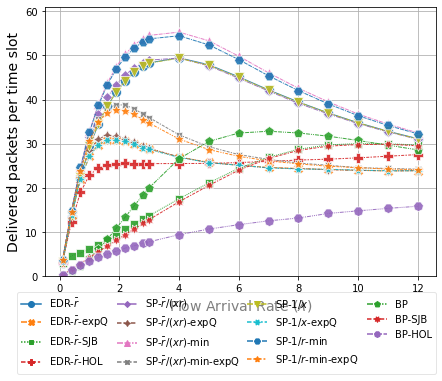

In [116]:
hue_order = []
# for opt in [0,7,27,50,60,57,67,5,25,45]:
# for opt in [0,50,60,7,27,57,67,5,25,45]:
for opt in [7,27,57,67,5,25, 45, 35,6,26,49,39,0,50,60]:
# for opt in [0,50,60,7,27,67,5,25,6,26,39,49]:
    hue_order.append(lgds[opt])

# key = 'delay'
# key = 'delivery'
# key = 'e2e'
key = 'delivery_cnt'
cf_radius = 1.0


item_dict={
    'delay': 'src_delay_mean',
    'delivery': 'delivery_mean',
#     'e2e': 'est_delay_mean',
#     'delay': 'src_delay_max',
#     'delivery': 'delivery_mean',
#     'e2e': 'est_delay_max',
    'delivery_cnt': 'cnt_out',
    'e2e': 'e2e2',
}
item = item_dict[key]

ylabel_dict={
    'delay': 'E2E delay of delivered packets (slots)',
    'delivery': 'Delivery rate',
    'delivery_cnt': 'Delivered packets per time slot',
    'e2e': 'End-to-End Delay (slots)'    
}
ylabel = ylabel_dict[key]

ymax_dict={
    'delay': 500, #160,
    'delivery': 1.05,
    'delivery_cnt': 61,
    'e2e': 1000
}
ymax = ymax_dict[key]
# if T==1000 and key != 'delivery':
#     ymax = 2* ymax

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

df_tmp = df[df['cf_radius']==cf_radius]
df_tmp = df_tmp[df_tmp['Algo'].isin(hue_order)]
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
sns.lineplot(x="arrival_rate", y=item, 
             hue="Algo", 
#              hue="cf_radius", 
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$', r'SP-$\bar{r}/r$'],
#              hue_order=['BP', 'SP-Hop', 'EDR-10', r'SP-$1/x$', r'SP-$\bar{r}/(xr)$'],
             hue_order=hue_order,
             data=df_tmp, 
             ci=95,
#              err_style="band",
             err_style=None,
             linewidth=1.0, 
             palette="tab10", 
#             style="cf_radius",
             style="Algo",
             style_order=hue_order,
             markers=True,
             markersize=10,
             ax=ax,
             alpha=0.9,
             # mfc="None", 
             # mew=2, 
             # mec='black',
#                       mec
#                       mfc="None", 
                 )
L = ax.legend(
    fontsize=10,
    framealpha=0.5,
#     ncol=1,
#     loc='upper center',
#     bbox_to_anchor=(1.00, 1.02), 
#     loc="upper left",
    bbox_to_anchor=(0.03, 0.0, 0.97, .12), 
    loc='lower left',
    ncol=4, 
#     loc='outside lower left',
    mode="expand", 
    borderaxespad=0.,
    bbox_transform=fig.transFigure,
)

# ax.get_legend().remove()
# add_patch(L)

# for i in range(len(lgds)):
#     L.get_texts()[i].set_text(lgds[i])
# ax.set_ylim([0, 510])
# ax.set_ylim([0, 350])
if ymax > 0:
    ax.set_ylim([0, ymax])
ax.grid(True)
ax.set_xlabel('Flow Arrival Rate ($\lambda$)', fontsize=14)
# ax.set_ylabel('End-to-End Delay (time slots)', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
# fname = '../fig/SP_BP_{}_cali_{}.pdf'.format(csvfile.split('.')[0], key)
# fname = '../fig/SP_BP_{}_{}.pdf'.format(csvfile.split('.')[0], key)
fname = '../fig/SP_BP_{}ir_{:.0f}_{}_algos_{}_load.pdf'.format(csvfile.split('ir')[0], cf_radius, key, postfix)
print(fname)
# fig.set_size_inches(8, 4.8)
plt.tight_layout(pad=0.01)
l, b, w, h = ax.get_position().bounds
ax.set_position([l, b+0.14, w, h-0.14])
fig.set_size_inches(6, 5.10)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


In [227]:
l, b, w, h = ax.get_position().bounds
print(l,b,w,h)

0.08732638888888891 0.11227933541017654 0.9124421296296297 0.8874610591900312


In [79]:
df.columns

Index(['filename', 'seed', 'num_nodes', 'm', 'T', 'cf_radius', 'cf_degree',
       'opt', 'Algo', 'num_flows', 'z', 'arrival_rate', 'src_delay_mean',
       'src_delay_max', 'src_delay_std', 'est_delay_mean', 'est_delay_max',
       'est_delay_std', 'delivery_mean', 'delivery_max', 'delivery_std',
       'active_links', 'runtime', 'f_case', 'cnt_out_total', 'cnt_in_total',
       'delivery_total'],
      dtype='object')

In [118]:
df_res.groupby(['filename','seed','cf_radius','opt','num_flows','runtime','arrival_rate']).mean()

num_nodes  \
filename                              seed cf_radius opt num_flows runtime    arrival_rate              
poisson_graph_seed500_m8_n100_f17.mat 500  1.0       39  31        87.620727  3.0               100.0   
                                                                   91.211485  3.2               100.0   
                                                                   91.675382  3.6               100.0   
                                                                   92.144585  4.8               100.0   
                                                                   92.253044  4.0               100.0   
...                                                                                               ...   
poisson_graph_seed510_m8_n100_f27.mat 510  1.0       39  47        114.410883 5.6               100.0   
poisson_graph_seed512_m8_n100_f19.mat 512  1.0       39  40        107.925420 3.0               100.0   
                                                                   108.732952 3.4               100.0   
                                                                   108.913186 3.2               100.0   
                                                                   111.992225 3.6               100.0   

                                                                                              m  \
filename                              seed cf_radius opt num_flows runtime    arrival_rate        
poisson_graph_seed500_m8_n100_f17.mat 500  1.0       39  31        87.620727  3.0           8.0   
                                                                   91.211485  3.2           8.0   
                                                                   91.675382  3.6           8.0   
                                                                   92.144585  4.8           8.0   
                                                                   92.253044  4.0           8.0   
...                                                                                         ...   
poisson_graph_seed510_m8_n100_f27.mat 510  1.0       39  47        114.410883 5.6           8.0   
poisson_graph_seed512_m8_n100_f19.mat 512  1.0       39  40        107.925420 3.0           8.0   
                                                                   108.732952 3.4           8.0   
                                                                   108.913186 3.2           8.0   
                                                                   111.992225 3.6           8.0   

                                                                                                 T  \
filename                              seed cf_radius opt num_flows runtime    arrival_rate           
poisson_graph_seed500_m8_n100_f17.mat 500  1.0       39  31        87.620727  3.0           1000.0   
                                                                   91.211485  3.2           1000.0   
                                                                   91.675382  3.6           1000.0   
                                                                   92.144585  4.8           1000.0   
                                                                   92.253044  4.0           1000.0   
...                                                                                            ...   
poisson_graph_seed510_m8_n100_f27.mat 510  1.0       39  47        114.410883 5.6           1000.0   
poisson_graph_seed512_m8_n100_f19.mat 512  1.0       39  40        107.925420 3.0           1000.0   
                                                                   108.732952 3.4           1000.0   
                                                                   108.913186 3.2           1000.0   
                                                                   111.992225 3.6           1000.0   

                                                                                            cf_degree  \
filena

In [254]:
np.arange(0.1,3.0,0.3).size

10

## queue length vs expQ

In [64]:
ob_csv = os.path.join(outdir, "test_data_poisson_10_T_500_ir_1.0_opts_35-36-37-39_link-26.0_regular_observe.csv")
data = pd.read_csv(ob_csv)
data = data.loc[~((data['queue'] == 0))]

noise = np.random.uniform(-0.4, 0.4, [data.shape[0],]) 
data["queue_noise"] = data["queue"] + noise

data

,opt,t,queue,queue_exp,queue_noise
274,35,0,1.0,1.010000,1.274972
297,35,0,1.0,1.010000,0.612017
440,35,0,1.0,1.010000,1.062054
889,35,0,1.0,1.010000,1.376019
954,35,0,1.0,1.010000,1.319835
...,...,...,...,...,...
11399829,35,499,2.0,2.187371,2.048142
11399832,35,499,5.0,5.266706,5.085389
11399854,35,499,6.0,6.060000,5.749907
11399961,35,499,3.0,3.142831,2.962820


../fig/SP_BP_expQ_vs_queue_quadratic_regression3.pdf


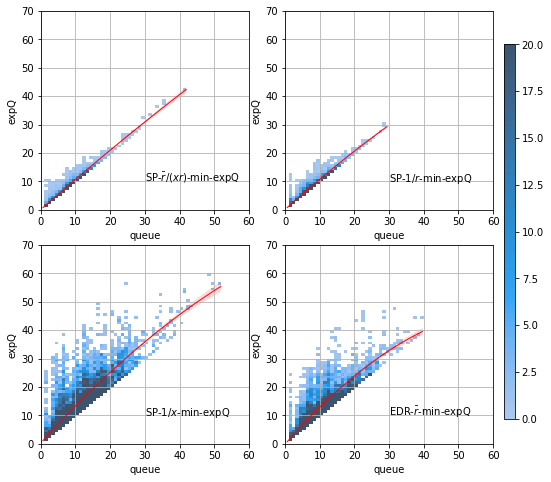

In [186]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(7.5, 6.5))
opts = [35,39, 36,37]

for idx in range(4):
    opt = opts[idx]
    ax=axs[int(idx/2), idx%2]
    ax.set_xlim(None, 60)
    ax.set_xticks(range(0, 61, 10))
    ax.set_ylim(None, 70)
    ax.set_yticks(range(0, 71, 10))
    ax.set_xlabel("queue")
    ax.set_ylabel("expQ")
#     ax.legend(lgds[opt], loc="lower right")
    ax.grid(True)
    ax.text(30,10, lgds[opt])

# fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 6.5))
plt.tight_layout(pad=0.01)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([.92, .12, .02, .8])


# opt=35

data1 = data.sample(n=40000, random_state=1)
# sns.kdeplot(
#     x="queue", 
#     y="queue_exp", 
# #     data=data[data['opt']==opt], 
#     data=data, 
#     hue="opt", 
#     fill=True,
#     ax=ax,
# )

# ax.set_xlabel("queue")
# ax.set_ylabel("expQ")
# ax.grid(True)

for idx in range(4):
    opt = opts[idx]
    ax=axs[int(idx/2), idx%2]
#     sns.kdeplot(
#         x="queue", 
#         y="queue_exp", 
#         data=data[data['opt']==opt], 
#         hue="opt", fill=True,
#     )
    sns.histplot(
        data=data1[data1['opt']==opt], 
        x="queue", 
        y="queue_exp", 
        binwidth=1,
#         fill=True,
#         thresh=0, 
#         levels=10, 
#         cmap="hot_r",
#         kde=True,
        pmax=0.15,
        common_norm=True,
        legend=True,
        cbar=True, cbar_ax=cbar_ax, cbar_kws={"aspect":20},
#         label=lgds[opt],
        ax=ax,
    )
    sns.regplot(
        x="queue_noise", 
        y="queue_exp", 
        data=data1[data1['opt']==opt], 
        ax=ax,
        label=lgds[opt],
        marker="o", 
        # color=".3", 
        scatter=False,
        order=2,
        # scatter_kws={"alpha": 0.1, "facecolor":"None"},
        line_kws=dict(color="r", linewidth=1),
    )

#     sns.scatterplot(
#         x="queue_noise", 
#         y="queue_exp", 
#         data=data[data['opt']==opt], 
#         marker=".",
#         ax=ax,
#         label=lgds[opt],
#         )
    ax.set_xlabel("queue")
    ax.set_ylabel("expQ")
#     ax.set_xlabel(r"$Q_i^{(c)}$")
#     ax.set_ylabel(r"$g\left(Q_i^{(c)}\right)$")
#     ax.grid(True)
    


    
fname = '../fig/SP_BP_expQ_vs_queue_quadratic_regression3.pdf'
print(fname)
# fig.set_size_inches(8, 4.8)
# l, b, w, h = ax.get_position().bounds
# ax.set_position([l, b+0.14, w, h-0.14])
fig.set_size_inches(7.5, 6.5)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')

In [15]:
axs

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [20]:
axs[int(idx/2), idx%2]

<AxesSubplot:>

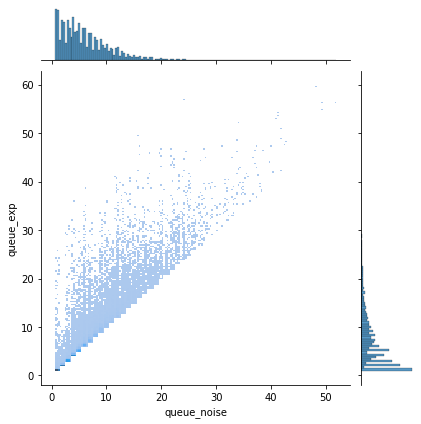

In [152]:
import matplotlib.cm as cm

sns.jointplot(
    data=data1, 
    x="queue_noise", 
    y="queue_exp", 
#     hue="opt",
    kind="hist",
#     gridsize=60,
    binwidth=0.3,
#     cmap=cm.jet
)
